In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn import tree
from sklearn.metrics import confusion_matrix
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pickle
#Configuramos pandas para mostrarnos 20 filas
pd.set_option('display.max_rows', 20)
pd.set_option('display.min_rows', 20)

In [51]:
 def validacion(model,X_train,y_train,X_test,y_test):
    y_random = []
    for i in range(len(y_test)):
        n = random.randint(0,1)
        y_random.append(n)
    print(sum(y_random==y_test)/len(y_test))
    print(confusion_matrix(y_test, y_random))

    y_pred_train=model.predict(X_train)
    print(sum(y_pred_train==y_train)/len(y_train))
    print(confusion_matrix(y_train, y_pred_train))

    y_pred_test=model.predict(X_test)
    print(sum(y_pred_test==y_test)/len(y_test))
    print(confusion_matrix(y_test, y_pred_test))
    
    #Predecimos que ocurrirá con las pólizas de test
    y_pred_test = model.predict(X_test)

    # Comprobamos los resultados
    print(classification_report(y_test, y_pred_test))

    # Medimos el posible sobreajuste comparando resultados sobre conjuntos de entrenamiento y test
    print('Precision en el set de Entrenamiento: {:.2f}'
         .format(model.score(X_train, y_train)))
    print('Precision en el set de test: {:.2f}'
         .format(model.score(X_test, y_test)))

    # Comparamos los resultados con el modelo dummy
    p_positivo=sum(y_train)/len(y_train)
    y_predicted_dummy=y_pred_test.copy()
    for i in range(0,len(y_test)):
        y_predicted_dummy[i]=random.choices([0,1], [1-p_positivo,p_positivo])[0]
    print('Predicción dummy con probabilidad positivo =',p_positivo)
    print(classification_report(y_test, y_predicted_dummy))
    # Sacamos un análisis de precision y recall de recurrencia para diferentes umbrales de probabilidad
    print('Análisis de precision y recall de positivos para diferentes umbrales de probabilidad')
    reporte_por_umbral_de_probabilidad=pd.DataFrame(columns=['Umbral de probabilidad', 'Precision', 'Recall'])
    for p in np.arange(0.5, 0.58, 0.01):
        report=classification_report(y_test, 1*(model.predict_proba(X_test).T[1]>=p),output_dict=True)
        reporte_por_umbral_de_probabilidad = reporte_por_umbral_de_probabilidad.append({'Umbral de probabilidad': p, 'Precision':report['1']['precision'], 'Recall':report['1']['recall']}, ignore_index=True)
    print(reporte_por_umbral_de_probabilidad) 
    print(datetime.datetime.now(),': Validacion del modelo terminada')
    return

In [4]:
#Cargamos el fichero de cotizaciones seleccionando las columnas relevantes para el modelo
path='C:\\Users\\manuel.decesar\\Desktop\\data_labqt\\'
df=pd.read_csv(path+'WIKI_PRICES_212b326a081eacca455e13140d7bb9db.csv', sep=',')[['ticker','date','adj_close','adj_volume']]  
print(len(df))
#fijamos los tipos de datos
df['date']=pd.to_datetime(df['date'])
print(len(df))
metadata=pd.read_csv(path+'us_equities_meta_data.csv')
df = pd.merge(df, metadata[["ticker","sector"]], on="ticker")
print(len(df))

15389314
15389314
12274396


In [5]:
#df=df.reset_index()
#Filtrar tickers sin suficiente volumen
df_ticker_volume=np.log10(df.groupby(['ticker'])['adj_volume'].sum())
df=df[df['ticker'].isin(df_ticker_volume[df_ticker_volume>8.211].index)]
#Filtrar tickers sin suficientes cotizaciones
df_ticker_cot=np.log10(df.groupby(['ticker'])['adj_close'].count())
df=df[df['ticker'].isin(df_ticker_cot[df_ticker_cot>3.104].index)]
#Filtrar registros sin volumen
df=df[df['adj_close']>0]
#Filtro de fecha
df=df[df.date>='2001-01-01']
#Establecemos índice (ticker y fecha)
df=df.set_index(['ticker','date'])
print(len(df))
#df

7710723


(7.967, 8.496]      204
(8.496, 8.737]      204
(8.737, 8.93]       204
(8.93, 9.091]       204
(9.091, 9.252]      204
(9.252, 9.405]      204
(9.405, 9.612]      204
(9.612, 9.87]       204
(9.87, 10.185]      204
(10.185, 11.728]    204
Name: adj_volume, dtype: int64
total de tickers 2197
mediana de volumen ajustado por ticker 5383.999999999998


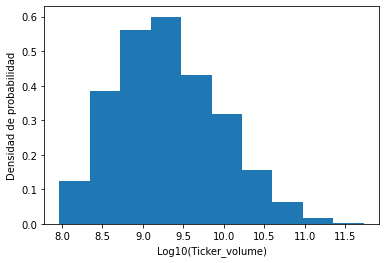

In [6]:
#Análisis volumen por ticker
%matplotlib inline
df_ticker_volume=np.log10(df.groupby(['ticker'])['adj_volume'].sum())
plt.hist(df_ticker_volume, density=True, bins=10)  # density=False would make counts
plt.ylabel('Densidad de probabilidad')
plt.xlabel('Log10(Ticker_volume)');
#percentiles
print(pd.qcut(df_ticker_volume,10).value_counts().sort_index())
print('total de tickers',len(df_ticker_cot))
print('mediana de volumen ajustado por ticker',10**df_ticker_cot.median())


(3.1047, 3.6201]     680
(3.6201, 3.6369]    1353
(3.6369, 3.637]        7
Name: adj_close, dtype: int64
mediana de número de cotizaciones por ticker 4333.999999999999


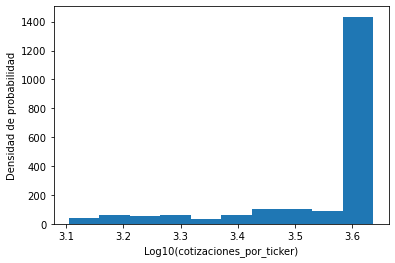

In [7]:
#Análisis cotizaciones por ticker
%matplotlib inline
df_ticker_cot=np.log10(df.groupby(['ticker'])['adj_close'].count())
plt.hist(df_ticker_cot, density=False, bins=10)  # density=False would make counts
plt.ylabel('Densidad de probabilidad')
plt.xlabel('Log10(cotizaciones_por_ticker)');
#percentiles
print(pd.qcut(df_ticker_cot,3).value_counts().sort_index())
print('mediana de número de cotizaciones por ticker',10**df_ticker_cot.median())

In [8]:
#Análisis nulos
print(df.reset_index()[df.reset_index().ticker.isnull()])
print(df.reset_index()[df.reset_index().date.isnull()])
print(df.reset_index()[df.reset_index().adj_close.isnull()])
print(df.reset_index()[df.reset_index().adj_volume.isnull()])

Empty DataFrame
Columns: [ticker, date, adj_close, adj_volume, sector]
Index: []
Empty DataFrame
Columns: [ticker, date, adj_close, adj_volume, sector]
Index: []
Empty DataFrame
Columns: [ticker, date, adj_close, adj_volume, sector]
Index: []
Empty DataFrame
Columns: [ticker, date, adj_close, adj_volume, sector]
Index: []


(0.999, 1498.0]     871
(1498.0, 1746.6]    865
(1746.6, 1918.0]    869
(1918.0, 2026.0]    887
(2026.0, 2040.0]    848
Name: adj_close, dtype: int64
número de fechas 4340
mediana de número de tickers por fecha 1802.0


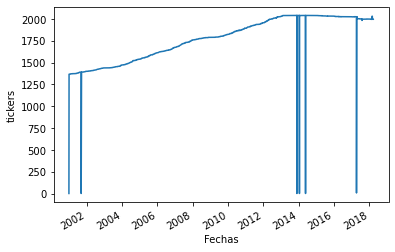

In [10]:
#Análisis discontinuidades de fechas
%matplotlib inline
df_date_tikers=df.groupby(['date'])['adj_close'].count()
df_date_tikers.plot()
plt.ylabel('tickers')
plt.xlabel('Fechas');
#percentiles
print(pd.qcut(df_date_tikers,5).value_counts().sort_index())
print('número de fechas',len(df_date_tikers))
print('mediana de número de tickers por fecha',df_date_tikers.median())

In [11]:
#tickers posibles
print(np.unique(df.index.get_level_values(0)))
#fechas posibles
print(np.unique(df.index.get_level_values(1)))

['A' 'AAL' 'AAN' ... 'ZNGA' 'ZTS' 'ZUMZ']
['2001-01-01T00:00:00.000000000' '2001-01-02T00:00:00.000000000'
 '2001-01-03T00:00:00.000000000' ... '2018-03-23T00:00:00.000000000'
 '2018-03-26T00:00:00.000000000' '2018-03-27T00:00:00.000000000']


In [12]:
#Filtrar muestra para desarrollo
#df=df.sort_values(by=['date'], ascending=False)[0:100000]
df=df.sort_values(by=['ticker'], ascending=False)[0:100000]
df=df.sort_values(by=['ticker','date'])
df=df.reset_index()
df=df.set_index(['ticker','date'])
print(len(df))

100000


In [13]:
#dummies para el sector
print(df.sector.unique())
df = pd.get_dummies(data=df, columns=['sector'])
pickle.dump(df.columns, open(path+'columnas', 'wb'))
print(datetime.datetime.now(),': Extraido fichero de transformación en dummies: columnas')
columnas=pickle.load(open(path+'columnas', 'rb'))
print(columnas)
df=df.reindex(labels =columnas, axis = 1, fill_value = 0)
df

['Basic Industries' 'Capital Goods' 'Energy' 'Public Utilities' 'Finance'
 'Technology' 'Health Care' 'Consumer Services' 'Consumer Non-Durables'
 'Transportation']
2021-12-22 17:25:52.706851 : Extraido fichero de transformación en dummies: columnas
Index(['adj_close', 'adj_volume', 'sector_Basic Industries',
       'sector_Capital Goods', 'sector_Consumer Non-Durables',
       'sector_Consumer Services', 'sector_Energy', 'sector_Finance',
       'sector_Health Care', 'sector_Public Utilities', 'sector_Technology',
       'sector_Transportation'],
      dtype='object')


adj_close  adj_volume  sector_Basic Industries  \
ticker date                                                         
X      2001-01-02  14.287317    685400.0                        1   
       2001-01-03  14.445233    875100.0                        1   
       2001-01-04  14.752756    622100.0                        1   
       2001-01-05  14.229137    700300.0                        1   
       2001-01-08  14.594839    405000.0                        1   
       2001-01-09  14.287317    415300.0                        1   
       2001-01-10  14.079531    654400.0                        1   
       2001-01-11  13.813566    511300.0                        1   
       2001-01-12  13.506044    499500.0                        1   
       2001-01-16  14.129400    589400.0                        1   
...                      ...         ...                      ...   
ZUMZ   2018-03-14  19.600000    357345.0                        0   
       2018-03-15  20.000000    599736.0                        0   
       2018-03-16  22.100000   2059778.0                        0   
       2018-03-19  23.400000    858257.0                        0   
       2018-03-20  23.800000    404873.0                        0   
       2018-03-21  23.950000    354092.0                        0   
       2018-03-22  23.350000    269607.0                        0   
       2018-03-23  23.550000    301584.0                        0   
       2018-03-26  24.650000    375320.0                        0   
       2018-03-27  23.600000    403884.0                        0   

                   sector_Capital Goods  sector_Consumer Non-Durables  \
ticker date                                                             
X      2001-01-02                     0                             0   
       2001-01-03                     0                             0   
       2001-01-04                     0                             0   
       2001-01-05                     0                             0   
       2001-01-08                     0                             0   
       2001-01-09                     0                             0   
       2001-01-10                     0                             0   
       2001-01-11                     0                             0   
       2001-01-12                     0                             0   
       2001-01-16                     0                             0   
...                                 ...                           ...   
ZUMZ   2018-03-14                     0                             0   
       2018-03-15                     0                             0   
       2018-03-16                     0                             0   
       2018-03-19                     0                             0   
       2018-03-20                     0                             0   
       2018-03-21                     0                             0   
       2018-03-22                     0                             0   
       2018-03-23                     0                             0   
       2018-03-26                     0                             0   
       2018-03-27                     0                             0   

                   sector_Consumer Services  sector_Energy  sector_Finance  \
ticker date                                                                  
X      2001-01-02                         0              0               0   
       2001-01-03                         0              0               0   
       2001-01-04                         0              0               0   
       2001-01-05                         0              0               0   
       2001-01-08                         0              0               0   
       2001-01-09                         0              0               0   
       2001-01-10                         0              0               0   
       2001-01-11                         0      

In [14]:
#Calculamos el retorno respecto al día anterior: incremento relativo del ticker respecto el día anterior
df['return_d']=df.groupby(level='ticker')['adj_close'].pct_change()
#Calculamos el retorno respecto a la semana anterior: incremento relativo del ticker respecto a la semana anterior
df['return_w']=df.groupby(level='ticker')['adj_close'].pct_change(periods=5)
#Calculamos el retorno respecto al mes anterior: incremento relativo del ticker respecto el mes anterior
df['return_m']=df.groupby(level='ticker')['adj_close'].pct_change(periods=20)
#Calculamos el retorno respecto al año anterior: incremento relativo del ticker respecto el año anterior
df['return_y']=df.groupby(level='ticker')['adj_close'].pct_change(periods=252)
#df

In [15]:
#Volatilidad semanal del retorno diario
df['volatility_w_rd']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: grp['return_d'].rolling(5).std())
#Volatilidad mensual del retorno diario
df['volatility_m_rd']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: grp['return_m'].rolling(20).std())
#Volatilidad anual del retorno diario
df['volatility_y_rd']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: grp['return_y'].rolling(252).std())
#df

In [16]:
#Cierre ajustado promediado semanal
df['adj_close_m_pw']=df.groupby(level='ticker')['adj_close'].apply(lambda grp: grp.rolling(5).mean())
#Cierre ajustado promediado mensual
df['adj_close_m_pm']=df.groupby(level='ticker')['adj_close'].apply(lambda grp: grp.rolling(20).mean())
#Cierre ajustado promediado anual
df['adj_close_m_py']=df.groupby(level='ticker')['adj_close'].apply(lambda grp: grp.rolling(252).mean())

In [17]:
#Retorno respecto al cierre ajustado promediado semanal
df['return_m_pw']=df.apply(lambda x: (x['adj_close']-x['adj_close_m_pw'])/x['adj_close_m_pw'], axis=1)
#Retorno respecto al cierre ajustado promediado mensual
df['return_m_pm']=df.apply(lambda x: (x['adj_close']-x['adj_close_m_pm'])/x['adj_close_m_pm'], axis=1)
#Retorno respecto al cierre ajustado promediado anual
df['return_m_py']=df.apply(lambda x: (x['adj_close']-x['adj_close_m_py'])/x['adj_close_m_py'], axis=1)

In [18]:
#Cierre ajustado promediado ponderado por volumen semanal
df['adj_close_vwm_pw']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: (grp['adj_close']*grp['adj_volume']).rolling(5).sum()/grp['adj_volume'].rolling(5).sum())
#Cierre ajustado promediado ponderado por volumen mensual
df['adj_close_vwm_pm']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: (grp['adj_close']*grp['adj_volume']).rolling(20).sum()/grp['adj_volume'].rolling(20).sum())
#Cierre ajustado promediado ponderado por volumen anual
df['adj_close_vwm_py']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: (grp['adj_close']*grp['adj_volume']).rolling(252).sum()/grp['adj_volume'].rolling(252).sum())
#df.loc['AMZN']

In [22]:
#Filtramos NaN
print(len(df))
df=df.dropna()
df=df.reset_index()
df=df.set_index(['ticker','date'])
print(len(df))

85309
85309


In [23]:
#Retorno respecto al cierre ajustado promediado ponderado semanal
df['return_vwm_pw']=df.apply(lambda x: (x['adj_close']-x['adj_close_vwm_pw'])/x['adj_close_vwm_pw'], axis=1)
df#Retorno respecto al cierre ajustado promediado ponderado mensual
df['return_vwm_pm']=df.apply(lambda x: (x['adj_close']-x['adj_close_vwm_pm'])/x['adj_close_vwm_pm'], axis=1)
df#Retorno respecto al cierre ajustado promediado ponderado anual
df['return_vwm_py']=df.apply(lambda x: (x['adj_close']-x['adj_close_vwm_py'])/x['adj_close_vwm_py'], axis=1)
#df

In [24]:
#me faltarían los tipos de tickers y los días de la semana


In [25]:
#Calculamos el retorno al día siguiente: incremento relativo del ticker en el día siguiente
df['return_f_d']=df.groupby(level='ticker')['adj_close'].pct_change().shift(periods=-1)

In [26]:
#Calculamos target (retorno>0)
df['return_gt_0']=df.apply(lambda x: 1 if x['return_f_d']>0 else 0, axis=1)

In [28]:
#Filtramos NaN
print(len(df))
df=df.dropna()
df=df.reset_index()
df=df.set_index(['ticker','date'])
print(len(df))

85309
85280


In [29]:
#Seleccionar date (para validación), features finales y target
#df=df.reset_index()[['date','return_d','return_w','return_m','return_y','return_m_pw','return_m_pm','return_m_py','volatility_w_rd','volatility_m_rd','volatility_y_rd','return_vwm_pw','return_vwm_pm','return_vwm_py','return_gt_0']]
df

adj_close  adj_volume  sector_Basic Industries  \
ticker date                                                         
X      2003-01-07  12.038583    574700.0                        1   
       2003-01-08  11.290520    975600.0                        1   
       2003-01-09  11.916805    922400.0                        1   
       2003-01-10  12.786645   2935100.0                        1   
       2003-01-13  13.352041   2894700.0                        1   
       2003-01-14  14.378452   2908300.0                        1   
       2003-01-15  14.752483   2527900.0                        1   
       2003-01-16  15.013435   3024600.0                        1   
       2003-01-17  14.943847   1530700.0                        1   
       2003-01-21  14.682896   1645700.0                        1   
...                      ...         ...                      ...   
ZUMZ   2018-03-13  20.000000    240835.0                        0   
       2018-03-14  19.600000    357345.0                        0   
       2018-03-15  20.000000    599736.0                        0   
       2018-03-16  22.100000   2059778.0                        0   
       2018-03-19  23.400000    858257.0                        0   
       2018-03-20  23.800000    404873.0                        0   
       2018-03-21  23.950000    354092.0                        0   
       2018-03-22  23.350000    269607.0                        0   
       2018-03-23  23.550000    301584.0                        0   
       2018-03-26  24.650000    375320.0                        0   

                   sector_Capital Goods  sector_Consumer Non-Durables  \
ticker date                                                             
X      2003-01-07                     0                             0   
       2003-01-08                     0                             0   
       2003-01-09                     0                             0   
       2003-01-10                     0                             0   
       2003-01-13                     0                             0   
       2003-01-14                     0                             0   
       2003-01-15                     0                             0   
       2003-01-16                     0                             0   
       2003-01-17                     0                             0   
       2003-01-21                     0                             0   
...                                 ...                           ...   
ZUMZ   2018-03-13                     0                             0   
       2018-03-14                     0                             0   
       2018-03-15                     0                             0   
       2018-03-16                     0                             0   
       2018-03-19                     0                             0   
       2018-03-20                     0                             0   
       2018-03-21                     0                             0   
       2018-03-22                     0                             0   
       2018-03-23                     0                             0   
       2018-03-26                     0                             0   

                   sector_Consumer Services  sector_Energy  sector_Finance  \
ticker date                                                                  
X      2003-01-07                         0              0               0   
       2003-01-08                         0              0               0   
       2003-01-09                         0              0               0   
       2003-01-10                         0              0               0   
       2003-01-13                         0              0               0   
       2003-01-14                         0              0               0   
       2003-01-15                         0              0               0   
       2003-01-16                         0      

In [30]:
#Zscore (normalizar? por día? para todos los tickets?)
#df['zscore']=df.groupby('date')['adj_close'].transform(lambda grp: (grp - grp.mean())/ grp.std())
#df

In [41]:
#Preparamos datasets de train y de test
df=df.sort_values('date')
lim=int(len(df)*.8)
X_train, y_train = df[['return_d','return_w','return_m','return_y','return_m_pw','return_m_pm','return_m_py','volatility_w_rd','volatility_m_rd','volatility_y_rd','return_vwm_pw','return_vwm_pm','return_vwm_py','sector_Basic Industries',
       'sector_Capital Goods', 'sector_Consumer Non-Durables',
       'sector_Consumer Services', 'sector_Energy', 'sector_Finance',
       'sector_Health Care', 'sector_Public Utilities', 'sector_Technology',
       'sector_Transportation']][0:lim],df[['return_gt_0']][0:lim].return_gt_0.values
X_test, y_test = df[['return_d','return_w','return_m','return_y','return_m_pw','return_m_pm','return_m_py','volatility_w_rd','volatility_m_rd','volatility_y_rd','return_vwm_pw','return_vwm_pm','return_vwm_py','sector_Basic Industries',
       'sector_Capital Goods', 'sector_Consumer Non-Durables',
       'sector_Consumer Services', 'sector_Energy', 'sector_Finance',
       'sector_Health Care', 'sector_Public Utilities', 'sector_Technology',
       'sector_Transportation']][lim:-1],df[['return_gt_0']][lim:-1].return_gt_0.values

In [42]:
#modelos
modelos=[]

In [52]:
#Construimos un modelo de arbol de decisión
model = tree.DecisionTreeClassifier(max_depth=3)
model = model.fit(X_train, y_train)
modelos.append(model)
y_1=[1]*len(y_test)
print(sum(y_1==y_test)/len(y_test))
print(confusion_matrix(y_test, y_1))

validacion(model,X_train,y_train,X_test,y_test)

0.507006742890648
[[   0 8408]
 [   0 8647]]
0.5017883318674875
[[4175 4233]
 [4264 4383]]
0.5235987335834896
[[25212  9489]
 [23013 10510]]
0.514805042509528
[[6097 2311]
 [5964 2683]]
              precision    recall  f1-score   support

           0       0.51      0.73      0.60      8408
           1       0.54      0.31      0.39      8647

    accuracy                           0.51     17055
   macro avg       0.52      0.52      0.49     17055
weighted avg       0.52      0.51      0.49     17055

Precision en el set de Entrenamiento: 0.52
Precision en el set de test: 0.51
Predicción dummy con probabilidad positivo = 0.4913666744840525
              precision    recall  f1-score   support

           0       0.49      0.50      0.50      8408
           1       0.50      0.49      0.50      8647

    accuracy                           0.50     17055
   macro avg       0.50      0.50      0.50     17055
weighted avg       0.50      0.50      0.50     17055

Análisis de precisi

C:\Users\manuel.decesar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\manuel.decesar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\manuel.decesar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\manuel.decesar\anac

In [44]:
#Modelo logistic regression
model =  LogisticRegression(random_state=0).fit(X_train, y_train)
modelos.append(model)

validacion(model,X_train,y_train,X_test,y_test)

C:\Users\manuel.decesar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.4971562591615362
[[4225 4183]
 [4393 4254]]
0.5202128283302064
[[24047 10654]
 [22079 11444]]
0.5048959249486954
[[5926 2482]
 [5962 2685]]
              precision    recall  f1-score   support

           0       0.50      0.70      0.58      8408
           1       0.52      0.31      0.39      8647

    accuracy                           0.50     17055
   macro avg       0.51      0.51      0.49     17055
weighted avg       0.51      0.50      0.48     17055

Precision en el set de Entrenamiento: 0.52
Precision en el set de test: 0.50
Predicción dummy con probabilidad de recurrencia = 0.4913666744840525
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      8408
           1       0.51      0.49      0.50      8647

    accuracy                           0.50     17055
   macro avg       0.50      0.50      0.50     17055
weighted avg       0.50      0.50      0.50     17055

Análisis de precision y recall de recurrencia para difere

C:\Users\manuel.decesar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\manuel.decesar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\manuel.decesar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\manuel.decesar\anac

In [45]:
#Modelo de vecinos más cercanos
model = KNeighborsClassifier(n_neighbors=20)
model.fit(X_train, y_train)
modelos.append(model)

validacion(model,X_train,y_train,X_test,y_test)

0.49838756962767516
[[4146 4262]
 [4293 4354]]
0.5983231707317073
[[24510 10191]
 [17213 16310]]
0.5038991498094401
[[5317 3091]
 [5370 3277]]
              precision    recall  f1-score   support

           0       0.50      0.63      0.56      8408
           1       0.51      0.38      0.44      8647

    accuracy                           0.50     17055
   macro avg       0.51      0.51      0.50     17055
weighted avg       0.51      0.50      0.50     17055

Precision en el set de Entrenamiento: 0.60
Precision en el set de test: 0.50
Predicción dummy con probabilidad de recurrencia = 0.4913666744840525
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      8408
           1       0.51      0.49      0.50      8647

    accuracy                           0.50     17055
   macro avg       0.50      0.50      0.50     17055
weighted avg       0.50      0.50      0.50     17055

Análisis de precision y recall de recurrencia para difer

Retornos diarios


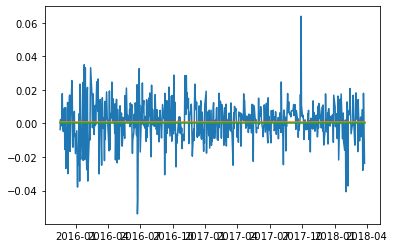

Retornos diarios acumulados sin reinvertir


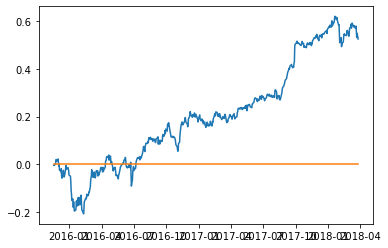

Retornos diarios acumulados reinvirtiendo


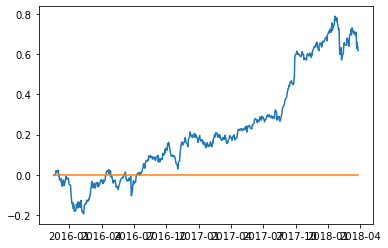

In [46]:
#Retornos diarios estrategia dummy (estrategia de repartir a partes iguales entre todos los tickers diariamente)
s=df[lim:-1].groupby('date')['return_f_d'].mean()
print('Retornos diarios')
plt.plot(s)
plt.plot(s.index,[s.mean()]*len(s.index))
plt.plot(s.index,[0]*len(s.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha sin reinvertir los retornos diarios
print('Retornos diarios acumulados sin reinvertir')
cs=s.cumsum()
plt.plot(cs)
plt.plot(cs.index,[0]*len(cs.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha reinvirtiendo los retornos diarios
print('Retornos diarios acumulados reinvirtiendo')
rcs=(s+1).cumprod()
plt.plot(rcs-1)
plt.plot(rcs.index,[0]*len(rcs.index))
plt.show()

<ipython-input-47-017e5fba3ca7>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s=(df[lim:-1])[df['return_d']>0].groupby('date')['return_f_d'].mean()


Retornos diarios


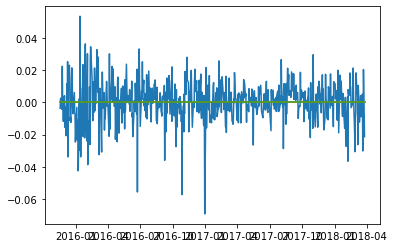

Retornos diarios acumulados sin reinvertir


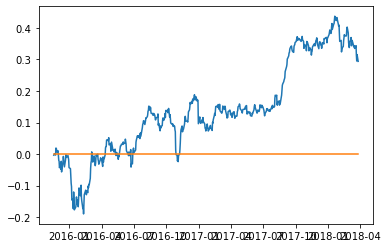

Retornos diarios acumulados reinvirtiendo


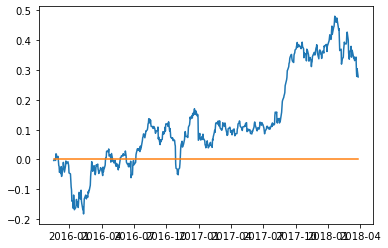

In [47]:
#Retornos diarios estrategia básica (estrategia de repartir diariamente a partes iguales entre todos los tickers con retorno positivo respecto al día anterior)
s=(df[lim:-1])[df['return_d']>0].groupby('date')['return_f_d'].mean()
print('Retornos diarios')
plt.plot(s)
plt.plot(s.index,[s.mean()]*len(s.index))
plt.plot(s.index,[0]*len(s.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha sin reinvertir los retornos diarios
print('Retornos diarios acumulados sin reinvertir')
cs=s.cumsum()
plt.plot(cs)
plt.plot(cs.index,[0]*len(cs.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha reinvirtiendo los retornos diarios
print('Retornos diarios acumulados reinvirtiendo')
rcs=(s+1).cumprod()
plt.plot(rcs-1)
plt.plot(rcs.index,[0]*len(rcs.index))
plt.show()

Retornos diarios


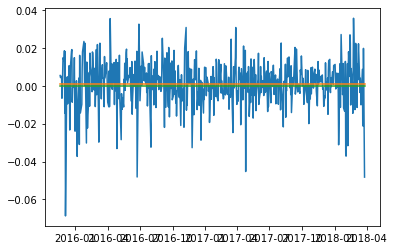

Retornos diarios acumulados sin reinvertir


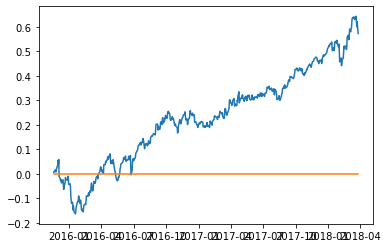

Retornos diarios acumulados reinvirtiendo


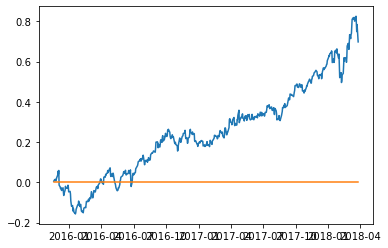

In [48]:
#Retornos diarios modelo básico (estrategia de repartir diariamente a partes iguales entre todos los tickers predichos con retorno positivo al día siguiente)
s=((df[lim:-1])[[ True if x==1 else False for x in modelos[0].predict(X_test)]]).groupby('date')['return_f_d'].mean()
print('Retornos diarios')
plt.plot(s)
plt.plot(s.index,[s.mean()]*len(s.index))
plt.plot(s.index,[0]*len(s.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha sin reinvertir los retornos diarios
print('Retornos diarios acumulados sin reinvertir')
cs=s.cumsum()
plt.plot(cs)
plt.plot(cs.index,[0]*len(cs.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha reinvirtiendo los retornos diarios
print('Retornos diarios acumulados reinvirtiendo')
rcs=(s+1).cumprod()
plt.plot(rcs-1)
plt.plot(rcs.index,[0]*len(rcs.index))
plt.show()

Siguiente:

features: día de la semana, macd,zscore del precio (power point)

marcar features con x_ y target con y_ para luego seleccionarlas (como en ejemplo de Manu)

añadir precisión en función del umbral de probabilidad

more comlex model 

crossvalidation: selección de atributos e hiperparámetros del modelo